In [5]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mpld3; mpld3.enable_notebook()
import seaborn as sns; sns.set();



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Random forest

### Out-of-bag score

### Feature importances

In [ ]:
from mpld3 import plugins, utils


class DragPlugin(plugins.PluginBase):
    JAVASCRIPT = r"""
    mpld3.register_plugin("drag", DragPlugin);
    DragPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    DragPlugin.prototype.constructor = DragPlugin;
    DragPlugin.prototype.requiredProps = ["id"];
    DragPlugin.prototype.defaultProps = {}
    function DragPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
        mpld3.insert_css("#" + fig.figid + " path.dragging",
                         {"fill-opacity": "1.0 !important",
                          "stroke-opacity": "1.0 !important"});
    };

    DragPlugin.prototype.draw = function(){
        var obj = mpld3.get_element(this.props.id);

        var drag = d3.behavior.drag()
            .origin(function(d) { return {x:obj.ax.x(d[0]),
                                          y:obj.ax.y(d[1])}; })
            .on("dragstart", dragstarted)
            .on("drag", dragged)
            .on("dragend", dragended);

        obj.elements()
           .data(obj.offsets)
           .style("cursor", "default")
           .call(drag);

        function dragstarted(d) {
          d3.event.sourceEvent.stopPropagation();
          d3.select(this).classed("dragging", true);
        }

        function dragged(d, i) {
          d[0] = obj.ax.x.invert(d3.event.x);
          d[1] = obj.ax.y.invert(d3.event.y);
          d3.select(this)
            .attr("transform", "translate(" + [d3.event.x,d3.event.y] + ")");
        }

        function dragended(d) {
          d3.select(this).classed("dragging", false);
        }
    }
    """

    def __init__(self, points):
        if isinstance(points, mpl.lines.Line2D):
            suffix = "pts"
        else:
            suffix = None

        self.dict_ = {"type": "drag",
                      "id": utils.get_id(points, suffix)}





f, axarr = plt.subplots(1, 2, figsize=(10, 5))
red = axarr[0].scatter([0], [0], c='r', s=1000)
axarr[1].scatter([0], [0], c='b', s=1000)

plugins.connect(fig, DragPlugin(red))
red.get_array()


In [6]:
def get_grid(data, step=0.1):
    x_min, x_max = data.x.min() - 1, data.x.max() + 1
    y_min, y_max = data.y.min() - 1, data.y.max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))

from sklearn.cross_validation import cross_val_score

def get_score(X, y, cl):
    return cross_val_score(cl, X, y, cv=5, scoring='mean_squared_error').mean()

def show_classifier(X, y, cl,
                    feature_modifier=lambda x: x,
                    proba=True,
                    print_score=False,
                    grid=None):
    if not grid:
        xs, ys = get_grid(X)
    else:
        xs, ys = grid
    xys = c_[ravel(xs), ravel(ys)]
    cl.fit(feature_modifier(X), y)
    if print_score:
        print("MSE = {}".format(get_score(feature_modifier(X), y, cl)))
    if proba:
        predicted = cl.predict_proba(feature_modifier(pd.DataFrame(xys, columns=('x', 'y'))))[:,1].reshape(xs.shape)
    else:
        predicted = cl.predict(feature_modifier(pd.DataFrame(xys, columns=('x', 'y')))).reshape(xs.shape)
    pcolormesh(xs, ys, predicted)
    scatter(X.x, X.y, c=y, alpha=0.5)
    autoscale(tight=True)
    return cl

# Линейные классификаторы

$$a(x) = sign(\left<w^Tx\right> - w_0)$$

F:\Anaconda3\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
F:\Anaconda3\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


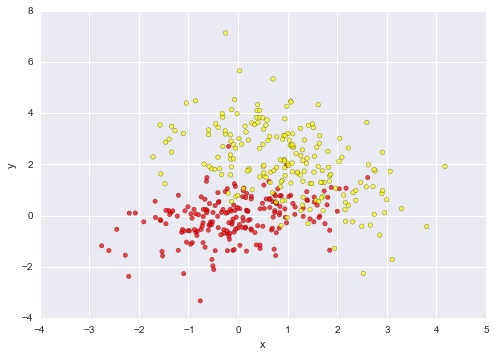

In [7]:
n = 200
random = np.random.RandomState(17)
df1 = pd.DataFrame(data=random.multivariate_normal((0,0), [[1, 0.3], [0.3, 0.7]], n), columns=['x', 'y'])
df1['target'] = 0
df2 = pd.DataFrame(data=random.multivariate_normal((1,2), [[1, -0.5], [-0.5, 1.6]], n), columns=['x', 'y'])
df2['target'] = 1
data = pd.concat([df1, df2], ignore_index=True)
features = data[['x', 'y']]
data.plot(kind='scatter', x='x', y='y', c='target', colormap='autumn', alpha=0.75, colorbar=False);

In [ ]:
from sklearn.svm import LinearSVC
big_grid = get_grid(features, 0.01)
show_classifier(features, data.target, 
                LinearSVC(),
                grid=big_grid,
                proba=False);

## Градиентный спуск¶

$$M_i(w, w_0) = y_i(\left<x, w\right> - w_0)$$
$$\sum_{i=1}^l \mathscr{L}(M(x_i)) \to min$$

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
random = np.random.RandomState(11)
n_iters = 20
figure(figsize=(10, 8 * n_iters))
xs, ys = get_grid(data, 0.05)
xys = c_[ravel(xs), ravel(ys)]
clf = SGDClassifier(alpha=1, l1_ratio=0)
train_objects = data.ix[random.choice(data.index, n_iters)]
for iteration in xrange(n_iters):
    new_object = train_objects.iloc[iteration]
    clf = clf.partial_fit([new_object[['x', 'y']]], [new_object.target], classes=[0, 1])
    subplot(n_iters, 1, iteration + 1)
    title("objets count = {}".format(iteration + 1))
    predicted = clf.predict(xys).reshape(xs.shape)
    pcolormesh(xs, ys, predicted)
    processed_objects = train_objects.head(iteration + 1)
    scatter(processed_objects.x, processed_objects.y, c=processed_objects.target, alpha=0.5)
    scatter(new_object.x, new_object.y, marker='x')